In [4]:
import numpy as np
import meshplot as mp
import open3d as o3d
import pyvista as pv
import scipy.sparse as sp
import time
import torchio as tio
from scipy.ndimage import label, center_of_mass, affine_transform
import matplotlib.pyplot as plt

In [5]:
def fibonacci_sphere(samples):
    indices = np.arange(0, samples, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / samples)
    theta = np.pi * (1 + 5**0.5) * indices

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    return np.vstack((x, y, z)).T

def convert_pointcloud_to_mesh(points):
 
    point_cloud = pv.PolyData(points)
    mesh = point_cloud.delaunay_3d()
    surf = mesh.extract_surface()
    vertices = surf.points
    faces = surf.faces.reshape(-1, 4)[:, 1:]

    return vertices, faces

def mesh_to_dense_adjacency(vertices, faces):
    num_vertices = vertices.shape[0]
    adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=np.float32)

    # Extract edges from faces and fill the adjacency matrix
    for face in faces:
        i, j, k = face

        # Add edges between vertices of each triangle
        adjacency_matrix[i, j] = 1  # Edge between i and j
        adjacency_matrix[j, i] = 1  # Symmetric edge
        adjacency_matrix[j, k] = 1  # Edge between j and k
        adjacency_matrix[k, j] = 1  # Symmetric edge
        adjacency_matrix[k, i] = 1  # Edge between k and i
        adjacency_matrix[i, k] = 1  # Symmetric edge

    return adjacency_matrix

def calculate_rotation_matrix(v1: np.ndarray, v2: np.ndarray) -> np.ndarray: 
    # Normalize the vectors
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)

    # Compute the cross product (axis of rotation)
    axis = np.cross(v1, v2)
    axis_norm = np.linalg.norm(axis)

    # If the vectors are already the same, no rotation is needed
    if axis_norm == 0:
        # print("Vectors are the same!")
        return np.eye(3)

    # Normalize the axis of rotation
    axis = axis / axis_norm

    # Compute the angle between the vectors
    cos_theta = np.dot(v1, v2)
    sin_theta = axis_norm  # This is the norm of the cross product

    # Compute the skew-symmetric matrix K
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])

    # Rodrigues' rotation formula
    R = np.eye(3) + np.sin(np.arccos(cos_theta)) * K + (1 - cos_theta) * np.dot(K, K)

    return np.transpose(R)

def load_and_crop_example_image(img_path: str, seg_path: str, margin: float = 0.0):
    subject = tio.Subject(img = tio.ScalarImage(img_path),
                       seg = tio.LabelMap(seg_path))
    

    subject = tio.Resample(target=(1, 1, 1))(subject)

    seg_arr = subject.seg.numpy()[0]
    # seg_arr = (seg_arr > 0).astype(int)

    foreground_indices = np.where(seg_arr == 1)

    # Compute the size of the foreground along each dimension
    sizes = []
    for dim_indices in foreground_indices:
        dim_min = np.min(dim_indices)  # Minimum index in this dimension
        dim_max = np.max(dim_indices)  # Maximum index in this dimension
        size = dim_max - dim_min + 1   # Include both endpoints
        sizes.append(size)

    # Convert to NumPy array for convenience
    sizes = np.array(sizes)
    max_size = int(np.mean(sizes) * (1+margin))

    subject_new = tio.CropOrPad(target_shape=max_size, mask_name="seg")(subject)
    
    return subject_new.img.numpy()[0], subject_new.seg.numpy()[0]

def get_biggest_lesion_slice(volume, mask, axis=2):    
    
    # Label connected components in the segmentation mask
    labeled_mask, num_features = label(mask)
    
    # Identify the largest lesion
    region_sizes = np.array([(labeled_mask == i).sum() for i in range(1, num_features + 1)])
    largest_region_label = np.argmax(region_sizes) + 1
    
    # Compute the centroid of the largest lesion
    centroid = center_of_mass(mask, labeled_mask, largest_region_label)
    
    # Extract the index of the slice along the specified axis closest to the centroid
    slice_idx = int(round(centroid[axis]))
    
    # Extract the 2D slice from both the volume and the mask
    if axis == 0:
        slice_volume = volume[slice_idx, :, :]
        slice_mask = mask[slice_idx, :, :]
    elif axis == 1:
        slice_volume = volume[:, slice_idx, :]
        slice_mask = mask[:, slice_idx, :]
    elif axis == 2:
        slice_volume = volume[:, :, slice_idx]
        slice_mask = mask[:, :, slice_idx]
    
    return slice_volume, slice_mask

def rotate_array_around_center(array, rotation_matrix, order):
    # Compute the center of the array
    center = np.array(array.shape) / 2.0

    # Create the affine transformation matrix
    affine_matrix = np.eye(4)
    affine_matrix[:3, :3] = rotation_matrix

    # Translate to origin, apply rotation, and translate back
    translation_to_origin = np.eye(4)
    translation_to_origin[:3, 3] = -center

    translation_back = np.eye(4)
    translation_back[:3, 3] = center

    # Combine transformations: T_back * R * T_origin
    combined_transform = translation_back @ affine_matrix @ translation_to_origin

    # Apply the transformation using scipy.ndimage.affine_transform
    rotated_array = affine_transform(
        array,
        matrix=combined_transform[:3, :3],
        offset=combined_transform[:3, 3],
        order=order,  # Linear interpolation
        mode="constant",  # Padding mode for out-of-bounds regions
        cval=0  # Value for out-of-bounds regions
    )

    return rotated_array

def visualize(num_points, update_scene):
    surface_points = fibonacci_sphere(num_points)
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1)
    sphere.translate(-sphere.get_center())
    box = o3d.geometry.TriangleMesh.create_box(width=0.75, height=0.75, depth=0.75)
    box.translate(-box.get_center())
    plane = o3d.geometry.TriangleMesh.create_box(width=1.25, height=1.25, depth=0.05)
    plane.translate(-plane.get_center())
    arrow = o3d.geometry.TriangleMesh.create_arrow(
            cone_radius=0.1,     
            cone_height=0.25,     
            cylinder_radius=0.05, 
            cylinder_height=0.75,  
            resolution=10)                 

    p = mp.plot(np.zeros(1))
    p.add_transparent_mesh(v=np.array(sphere.vertices), f=np.array(sphere.triangles), c=np.array([1, 1, 1]), opacity=0.5)
    p.add_transparent_mesh(v=np.array(box.vertices), f=np.array(box.triangles), c=np.array([0, 0, 0]), opacity=0.5)
    p.add_points(surface_points, shading={"point_color": "red", "point_size": 0.3})

    vertices, faces = convert_pointcloud_to_mesh(surface_points)

    rot_matrix = calculate_rotation_matrix(np.array([0, 0, 1]), surface_points[0])
    box_vertices = np.array(box.vertices)
    arrow_vertices = np.array(arrow.vertices)
    plane_vertices = np.array(plane.vertices)

    box_vertices = np.dot(box_vertices, rot_matrix)
    arrow_vertices = np.dot(arrow_vertices, rot_matrix)
    plane_vertices = np.dot(plane_vertices, rot_matrix)

    p = mp.plot(np.zeros(3))
    p.add_transparent_mesh(v=vertices, f=faces, c=np.array([1, 1, 1]), opacity=0.5)
    p.add_points(vertices, shading={"point_color": "red", "point_size": 0.3})
    # p.add_points(np.array([0, 0, 1]).reshape(1,3), shading={"point_color": "green", "point_size": 0.3})
    p.add_points(surface_points[0].reshape(1,3), shading={"point_color": "green", "point_size": 0.3})
    p.add_transparent_mesh(v=box_vertices, f=np.array(box.triangles), c=np.array([0, 0, 0]), opacity=0.5)
    p.add_transparent_mesh(v=arrow_vertices, f=np.array(arrow.triangles), c=np.array([0, 0.5, 0]), opacity=0.5)
    p.add_transparent_mesh(v=plane_vertices, f=np.array(plane.triangles), c=np.array([0, 0.5, 0]), opacity=0.25)

    img, seg = load_and_crop_example_image(img_path="./example_image.nii.gz",
                                           seg_path="./example_segmentation.nii.gz")   

    # print(img.shape, seg.shape) 

    img_slice, seg_slice = get_biggest_lesion_slice(volume=img, mask=seg)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_slice, cmap="grey", origin='lower')
    ax[0].set_title(f"Volume Slice | Shape {img_slice.shape}")
    ax[0].axis('off')
    
    ax[1].imshow(seg_slice, cmap='hot', origin='lower')
    ax[1].set_title(f"Segmentation Mask (Largest Lesion)")
    ax[1].axis('off')
    plt.show()


    for i in range(1, num_points):
        rot_matrix = calculate_rotation_matrix(np.array([0, 0, 1]), surface_points[i])
        print(f"Rotation Matrix {i}")
        print(rot_matrix)
        box_vertices = np.array(box.vertices)
        arrow_vertices = np.array(arrow.vertices)
        plane_vertices = np.array(plane.vertices)

        box_vertices = np.dot(box_vertices, rot_matrix)
        arrow_vertices = np.dot(arrow_vertices, rot_matrix)
        # plane_vertices = np.dot(plane_vertices, rot_matrix)

        img_rotated = rotate_array_around_center(img, rot_matrix, order=1)
        seg_rotated = rotate_array_around_center(seg, rot_matrix, order=0)

        img_rot_slice, seg_rot_slice = get_biggest_lesion_slice(img_rotated, seg_rotated)

        if update_scene:
            p.update_object(oid=4, vertices=box_vertices)
            p.update_object(oid=5, vertices=arrow_vertices)
            # p.update_object(oid=6, vertices=plane_vertices)
            time.sleep(2)  

        else:
            p = mp.plot(np.zeros(3))
            p.add_transparent_mesh(v=vertices, f=faces, c=np.array([1, 1, 1]), opacity=0.5)
            p.add_points(vertices, shading={"point_color": "red", "point_size": 0.3})
            # p.add_points(np.array([0, 0, 1]).reshape(1,3), shading={"point_color": "green", "point_size": 0.3})
            p.add_points(surface_points[0].reshape(1,3), shading={"point_color": "green", "point_size": 0.3})
            p.add_transparent_mesh(v=box_vertices, f=np.array(box.triangles), c=np.array([0, 0, 0]), opacity=0.5)
            p.add_transparent_mesh(v=arrow_vertices, f=np.array(arrow.triangles), c=np.array([0, 0.5, 0]), opacity=0.5)
            p.add_transparent_mesh(v=plane_vertices, f=np.array(plane.triangles), c=np.array([0, 0.5, 0]), opacity=0.25)

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img_rot_slice, cmap="grey", origin='lower')
            ax[0].set_title(f"Volume Slice | Shape {img_rot_slice.shape}")
            ax[0].axis('off')
            
            ax[1].imshow(seg_rot_slice, cmap='hot', origin='lower')
            ax[1].set_title(f"Segmentation Mask (Largest Lesion)")
            ax[1].axis('off')
            plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

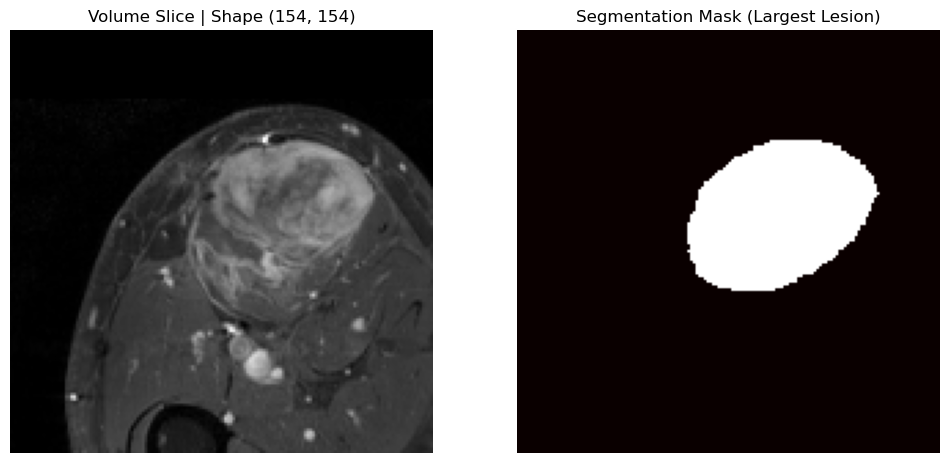

Rotation Matrix 1
[[ 0.89947257  0.04960005  0.43415312]
 [ 0.04960005  0.97552743 -0.21421034]
 [-0.43415312  0.21421034  0.875     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

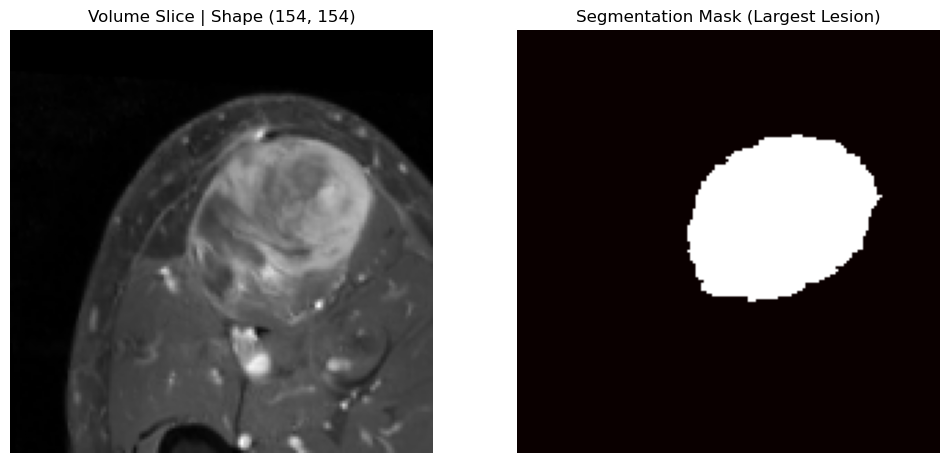

Rotation Matrix 2
[[ 0.80794216 -0.05590917 -0.58660347]
 [-0.05590917  0.98372451 -0.17076373]
 [ 0.58660347  0.17076373  0.79166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

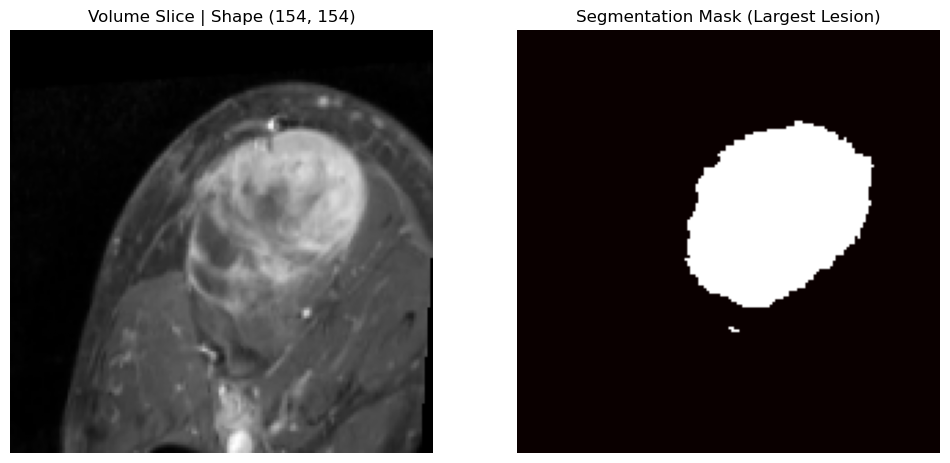

Rotation Matrix 3
[[ 0.92138227 -0.12941956  0.36647685]
 [-0.12941956  0.78695106  0.60328982]
 [-0.36647685 -0.60328982  0.70833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

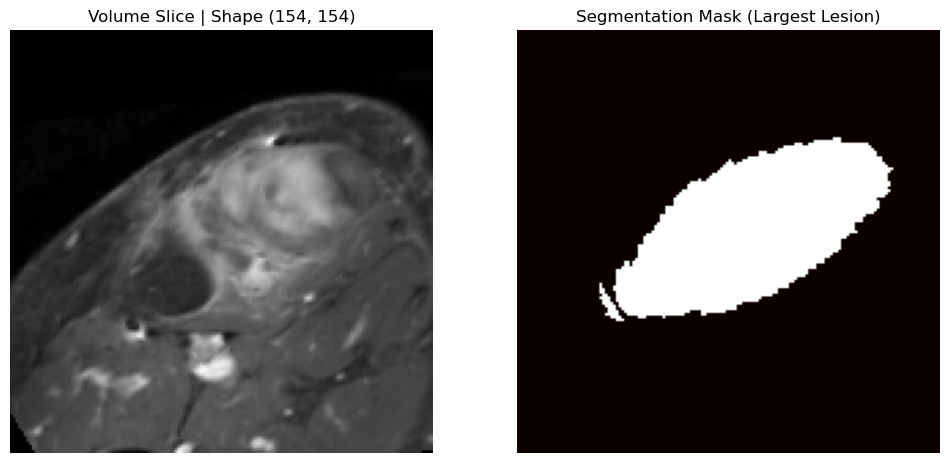

Rotation Matrix 4
[[ 0.98581479  0.07154183  0.15182544]
 [ 0.07154183  0.63918521 -0.76571799]
 [-0.15182544  0.76571799  0.625     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

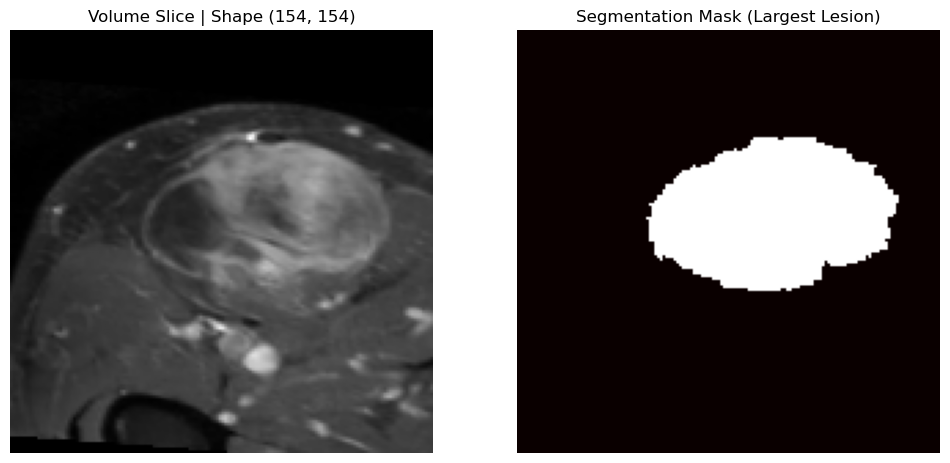

Rotation Matrix 5
[[ 0.70224745  0.21866261 -0.67752135]
 [ 0.21866261  0.83941922  0.49755606]
 [ 0.67752135 -0.49755606  0.54166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

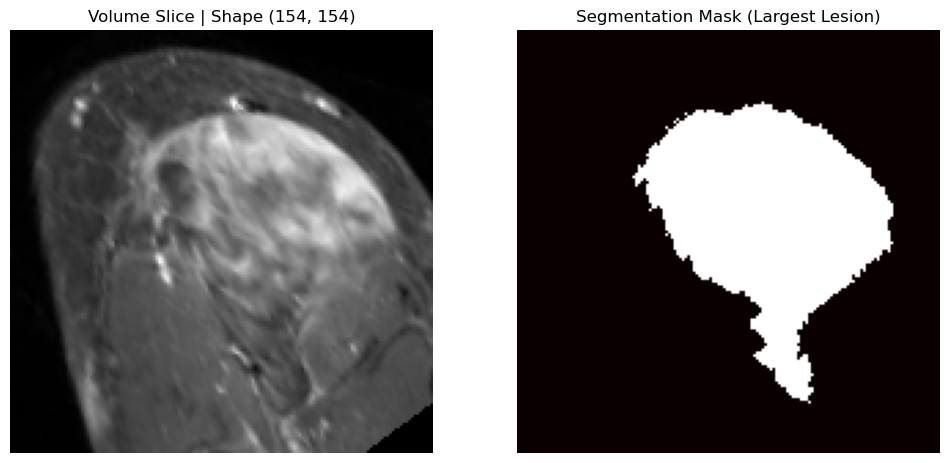

Rotation Matrix 6
[[ 0.46465031 -0.05815318  0.88358265]
 [-0.05815318  0.99368302  0.09598052]
 [-0.88358265 -0.09598052  0.45833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

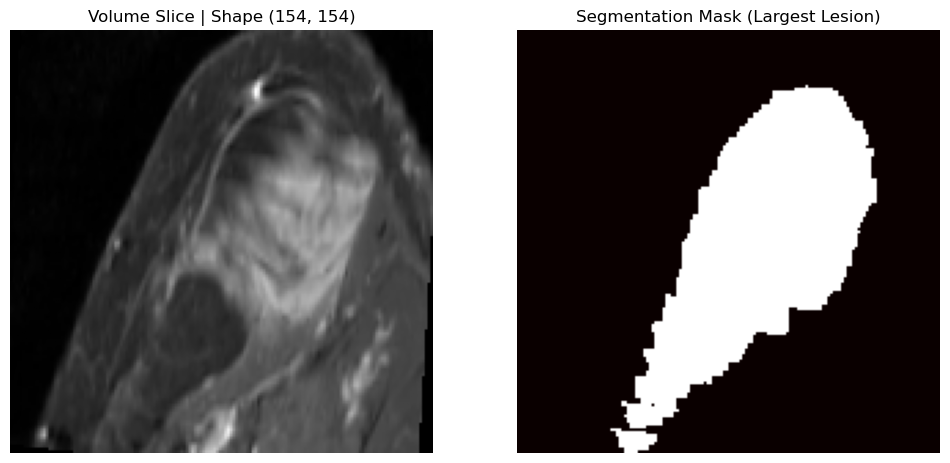

Rotation Matrix 7
[[ 0.72765959 -0.30990879 -0.61193796]
 [-0.30990879  0.64734041 -0.6963526 ]
 [ 0.61193796  0.6963526   0.375     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

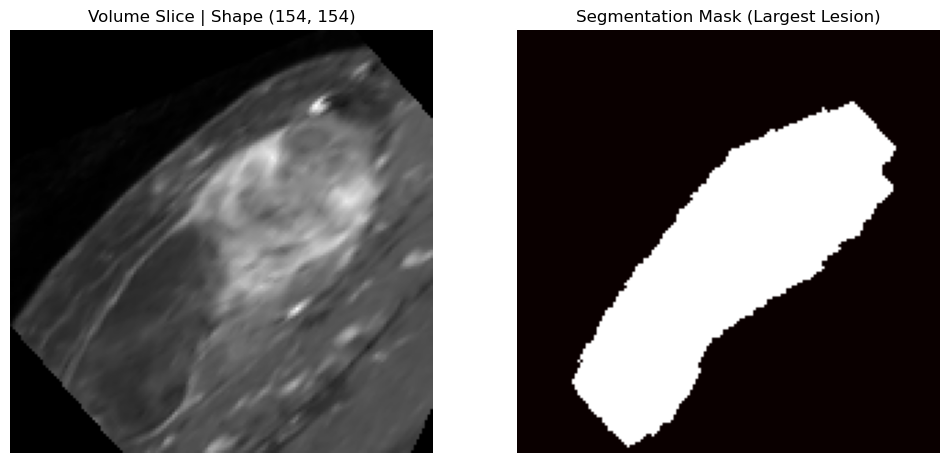

Rotation Matrix 8
[[ 0.99969756  0.0146334  -0.01976488]
 [ 0.0146334   0.29196911  0.9563158 ]
 [ 0.01976488 -0.9563158   0.29166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

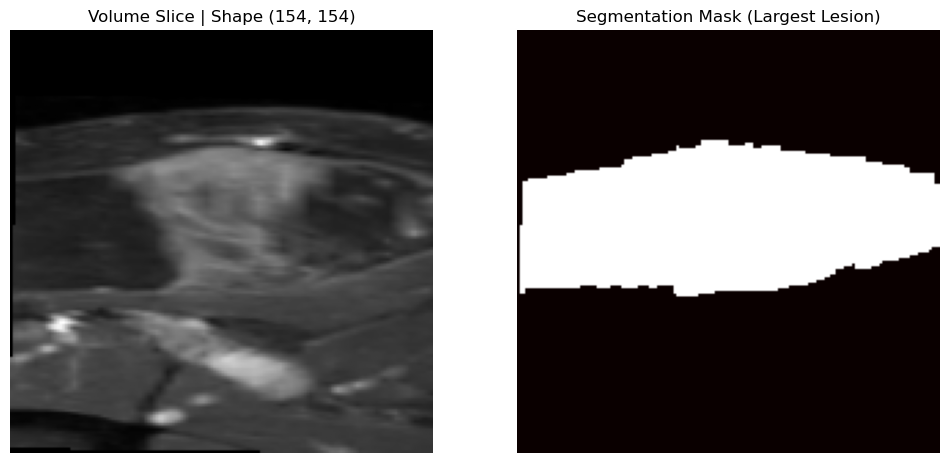

Rotation Matrix 9
[[ 0.62245078  0.39541082  0.67542972]
 [ 0.39541082  0.58588255 -0.70738385]
 [-0.67542972  0.70738385  0.20833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

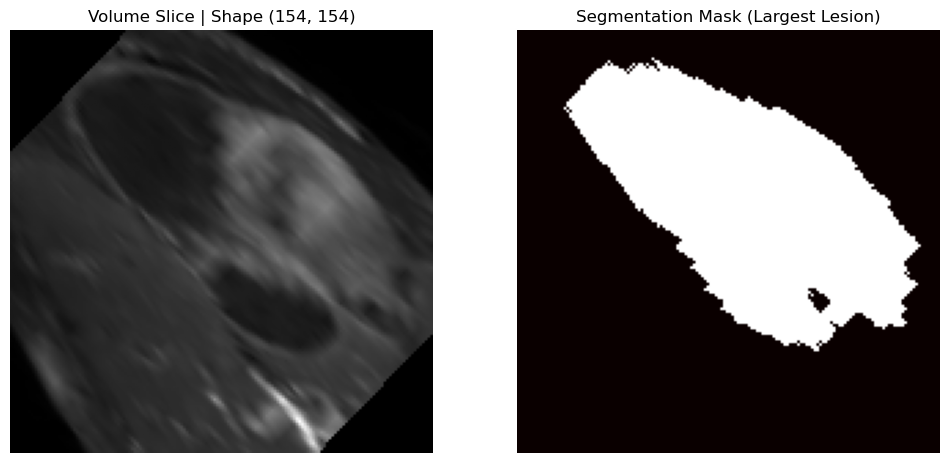

Rotation Matrix 10
[[ 0.12890713  0.05833931 -0.98993913]
 [ 0.05833931  0.99609287  0.06629874]
 [ 0.98993913 -0.06629874  0.125     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

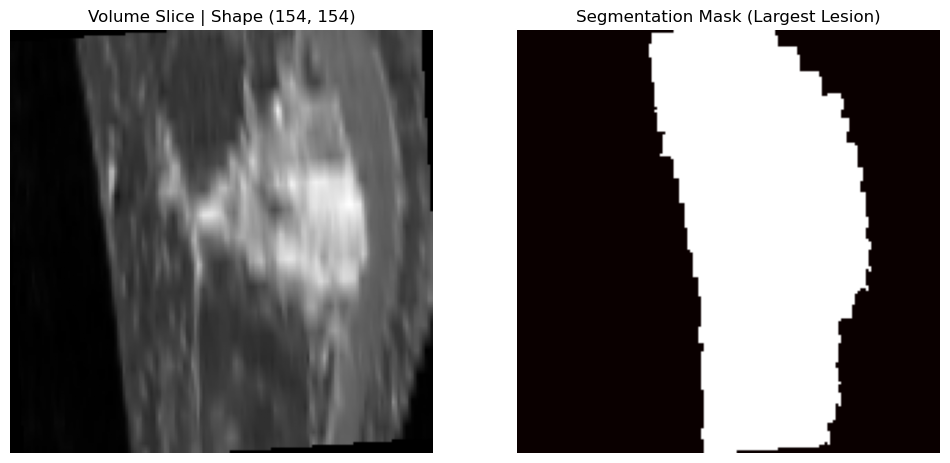

Rotation Matrix 11
[[ 0.41566518 -0.467483    0.78018082]
 [-0.467483    0.62600149  0.62416487]
 [-0.78018082 -0.62416487  0.04166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

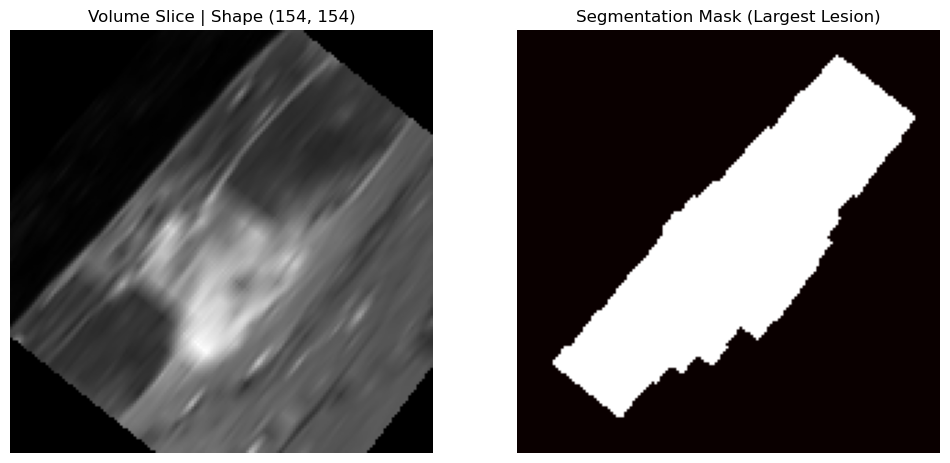

Rotation Matrix 12
[[ 0.97536082 -0.15829947 -0.15366374]
 [-0.15829947 -0.01702749 -0.98724432]
 [ 0.15366374  0.98724432 -0.04166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

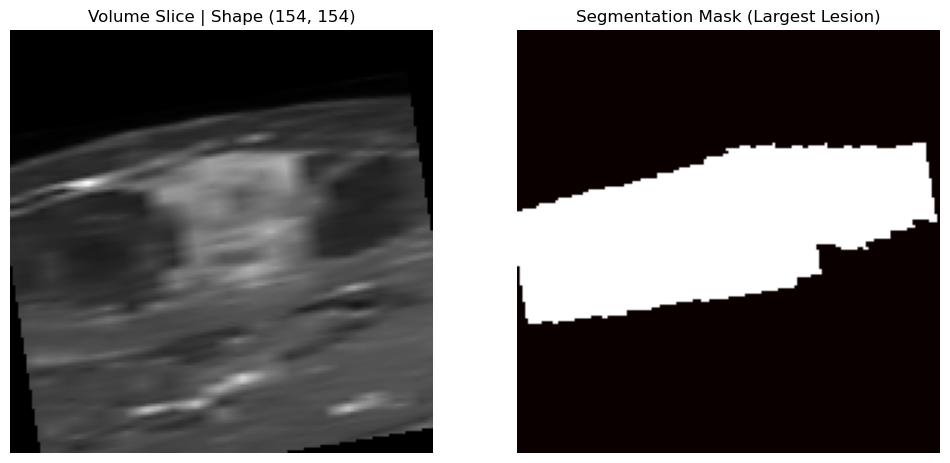

Rotation Matrix 13
[[ 0.65465936  0.51889119 -0.5497027 ]
 [ 0.51889119  0.22034064  0.82595517]
 [ 0.5497027  -0.82595517 -0.125     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

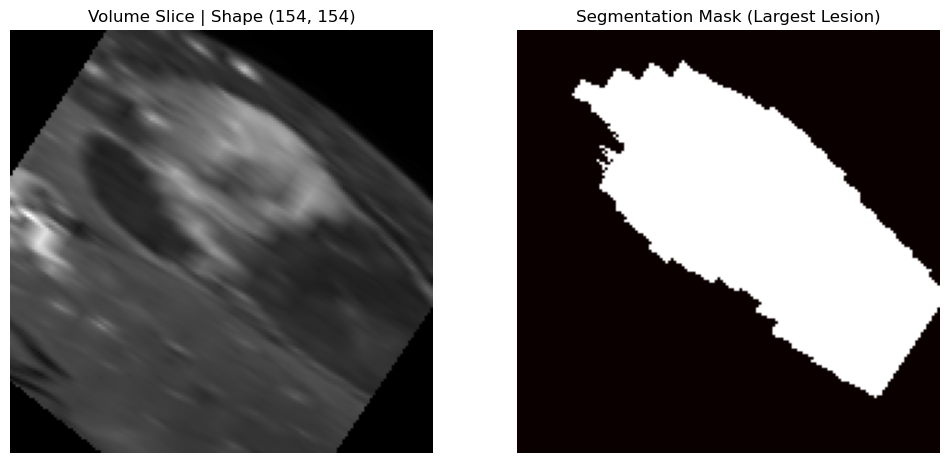

Rotation Matrix 14
[[-0.13896862  0.28107692  0.94957016]
 [ 0.28107692  0.93063529 -0.23433679]
 [-0.94957016  0.23433679 -0.20833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

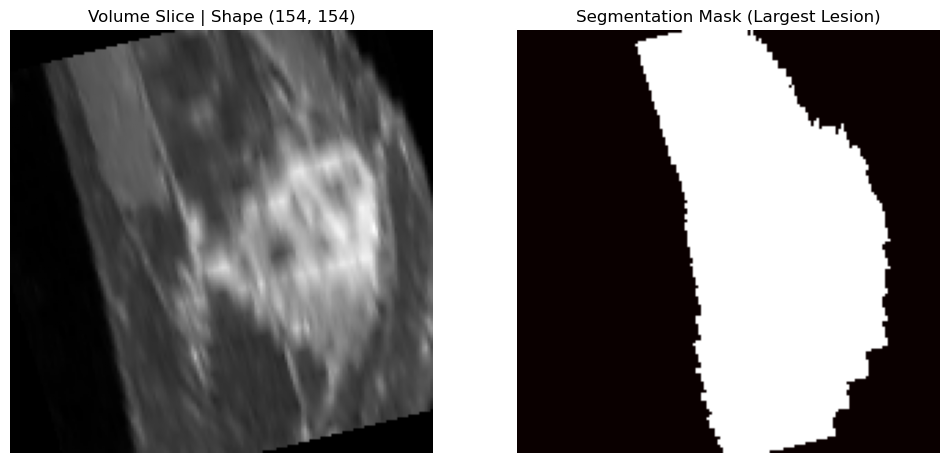

Rotation Matrix 15
[[ 0.00487563 -0.54322782 -0.83957118]
 [-0.54322782  0.70345771 -0.45831298]
 [ 0.83957118  0.45831298 -0.29166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

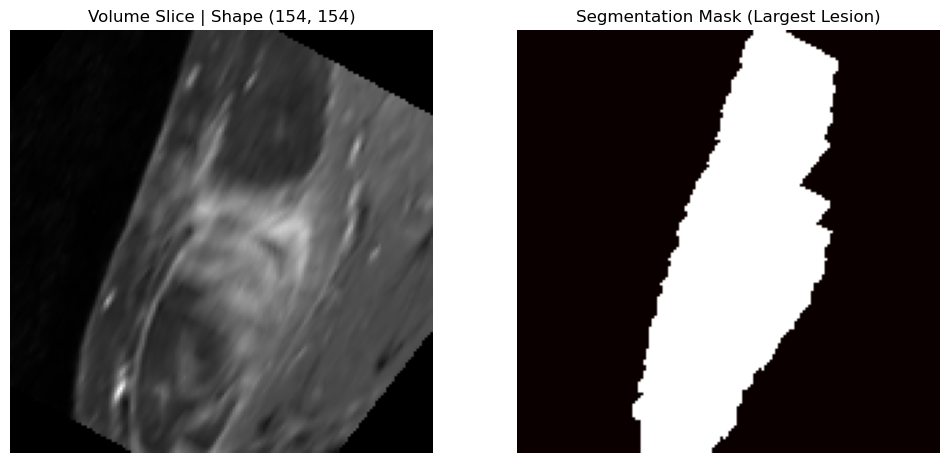

Rotation Matrix 16
[[ 0.85605343 -0.42095833  0.29994434]
 [-0.42095833 -0.23105343  0.87715928]
 [-0.29994434 -0.87715928 -0.375     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

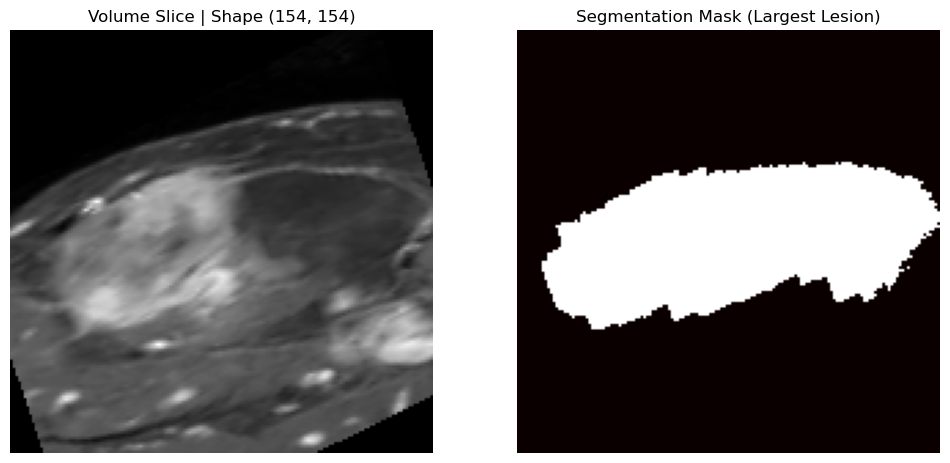

Rotation Matrix 17
[[ 0.76599536  0.53525564  0.35602319]
 [ 0.53525564 -0.22432869 -0.81435744]
 [-0.35602319  0.81435744 -0.45833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

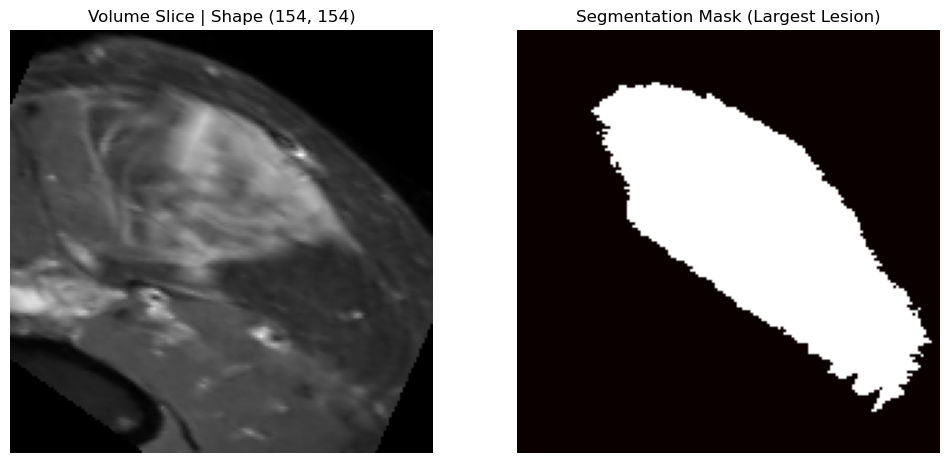

Rotation Matrix 18
[[-0.28874482  0.57092182 -0.76855365]
 [ 0.57092182  0.74707815  0.34047396]
 [ 0.76855365 -0.34047396 -0.54166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

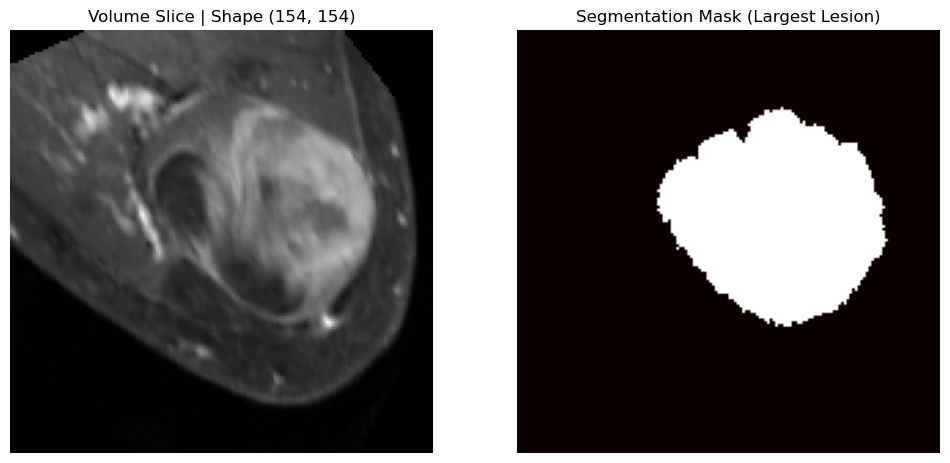

Rotation Matrix 19
[[-0.45970455 -0.49120518  0.73985756]
 [-0.49120518  0.83470455  0.24896947]
 [-0.73985756 -0.24896947 -0.625     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

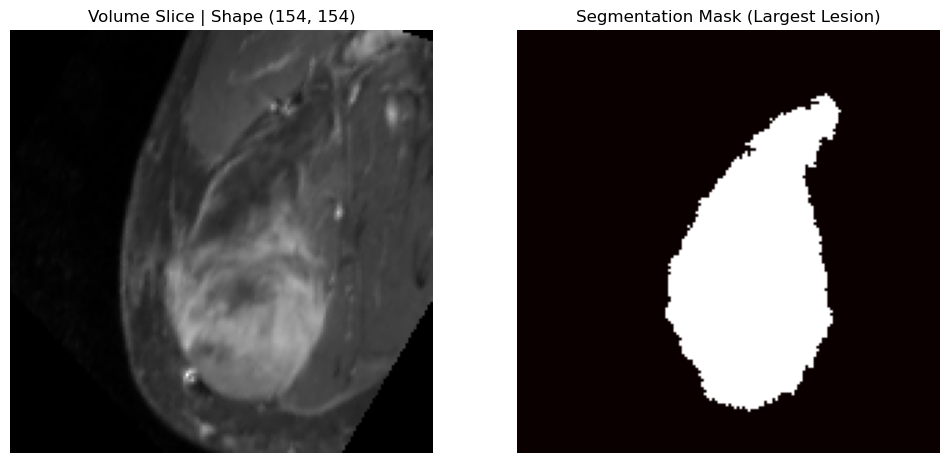

Rotation Matrix 20
[[ 0.60076728 -0.72293554 -0.34123727]
 [-0.72293554 -0.30910061 -0.61791667]
 [ 0.34123727  0.61791667 -0.70833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

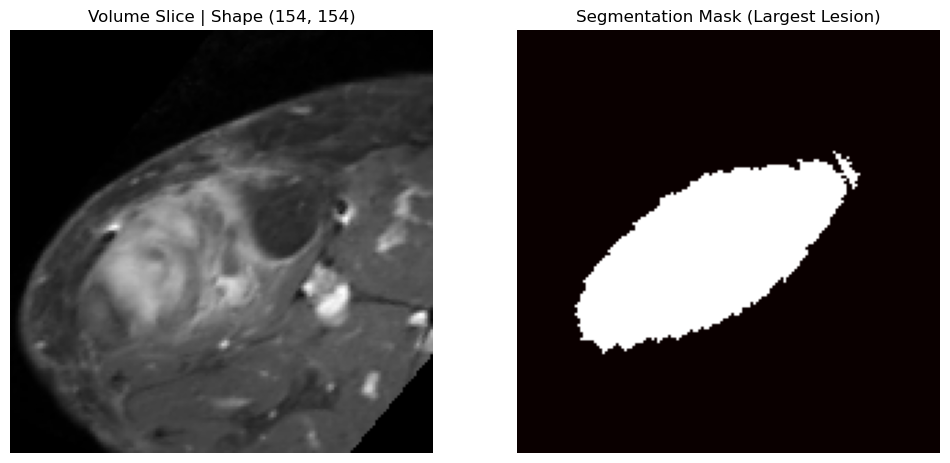

Rotation Matrix 21
[[ 0.90117731  0.4090127  -0.1434854 ]
 [ 0.4090127  -0.69284398  0.59386516]
 [ 0.1434854  -0.59386516 -0.79166667]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

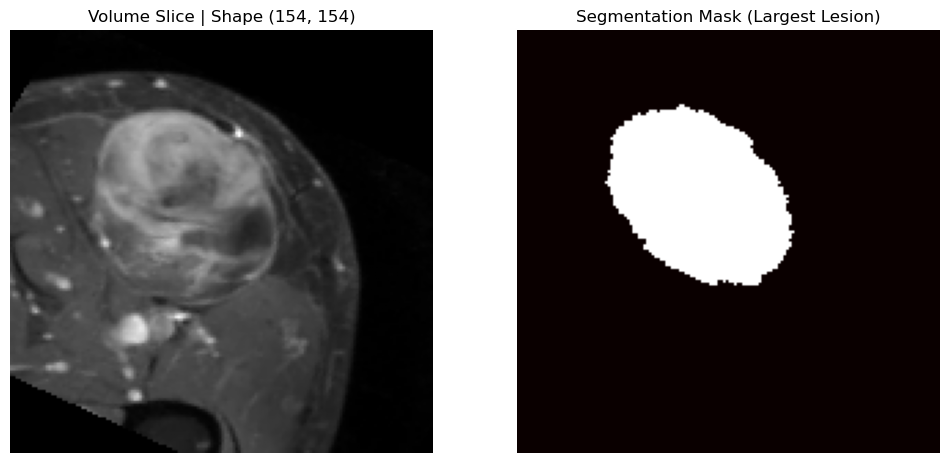

Rotation Matrix 22
[[-0.29097749  0.86830865  0.40171157]
 [ 0.86830865  0.41597749 -0.27019033]
 [-0.40171157  0.27019033 -0.875     ]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

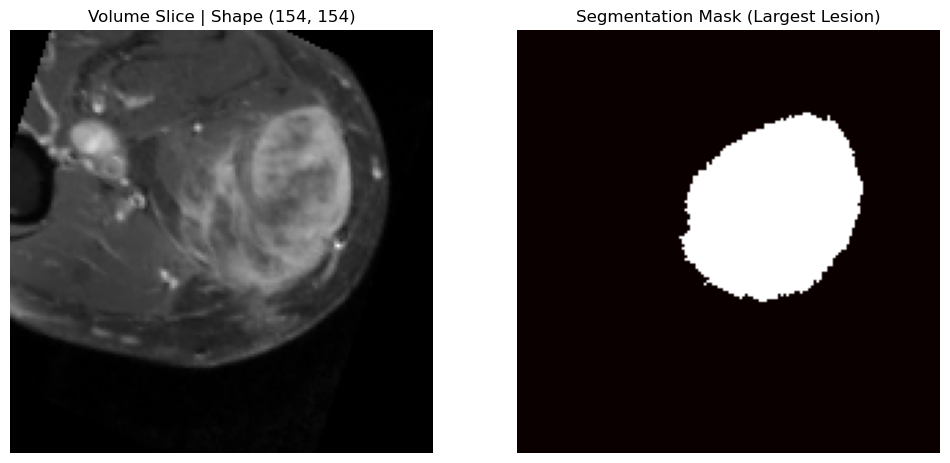

Rotation Matrix 23
[[-0.91487082 -0.28848759 -0.28246466]
 [-0.28848759  0.95653749 -0.04255512]
 [ 0.28246466  0.04255512 -0.95833333]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

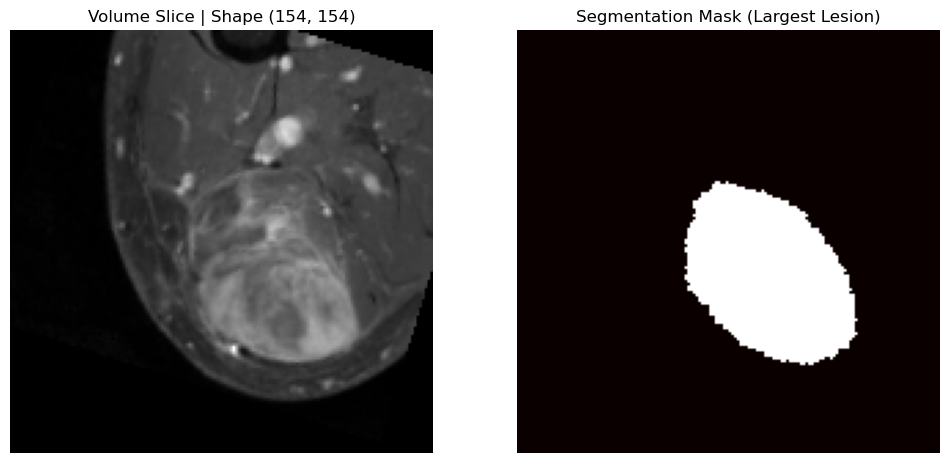

In [8]:
visualize(num_points=24, update_scene=False)